# RadioML Receiver

### A Recurrent Neural Network for Learning to demodulate and decode noisy signals over AWGN Channel.

___

# Environment Setup

Download & install and import packages for this tutorial


In [1]:
# Import local module
import time
import os
import sys
# a hack to import module from different directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import multiprocessing as mp
import random 
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

# For baseline comparision
from radioml.metrics import get_ber_bler
from radioml.models import Baseline 

# For data generator
from radioml.dataset import RadioDataGenerator

# For visualization
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

print("\nEnvironment setup is completed.")


Environment setup is completed.


# Define parameters for this experiment

In [3]:
DATA_LENGTH  = 100
DATA_RATE    = 1/2
SNR_TRAIN    = 8.0 

modem = QAMModem(4) 
trellis = Trellis(memory = np.array([2]),
                  g_matrix = np.array([[0o7, 0o5]]))

## Create training data generator and validation set

CPU times: user 577 ms, sys: 257 ms, total: 834 ms
Wall time: 4.77 s


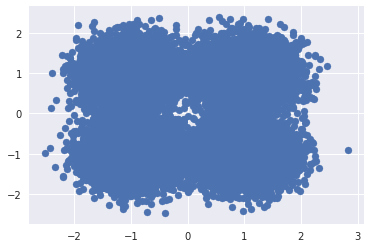

In [4]:
%%time
radio = RadioDataGenerator(DATA_LENGTH, 40, 1, modulation_scheme='QPSK')

training_generator   = radio.ecc_data_generator(1/1000, SNR_TRAIN, batch_size=256, num_cpus=16, seed=None)
x_dev, y_dev =  next(radio.ecc_data_generator(1/1000, SNR_TRAIN, batch_size=12800, num_cpus=16, seed=2018))

## Visualize samples
equalized_data, data_estimate = next(training_generator)
plt.scatter(equalized_data.reshape((-1, 2))[...,0],
           equalized_data.reshape((-1, 2))[...,1])

## Measure baseline performance (Classic Demodulation + Viterbi)


In [5]:
baseline_receiver = Baseline(modulation_scheme='QPSK')

with mp.Pool(mp.cpu_count()) as pool:
    baseline_estimated = pool.map(baseline_receiver, [i.view(complex) for i in x_dev])
    data_estimate = np.array(baseline_estimated)
    data_original = np.squeeze(y_dev, -1)  # (batch, 200, 1) to (batch, 200)
    
ber, bler = get_ber_bler(data_estimate, 
                         data_original)
print('Baseline BER: %.4f' % ber)
print('Baseline BLER: %.5f' % bler)

Baseline BER: 0.0007
Baseline BLER: 0.04805


 # Construct a Recurrent  Neural Network 
 
Here we implement an RNN that will read encoded complex inputs and estimate the orignal message bits

In [6]:
# For end2end receiver
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed

# To avoid accidenttally run this cell multiple times.
tf.keras.backend.clear_session()

inputs  = Input(shape=(None, 2))
x = Bidirectional(LSTM(200, return_sequences=True))(inputs)
x = Bidirectional(LSTM(200, return_sequences=True))(x)
outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 400)         324800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         961600    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           401       
Total params: 1,286,801
Trainable params: 1,286,801
Non-trainable params: 0
_________________________________________________________________


## Define Loss Function / Metrics (BER/BLER) for training.

In [7]:
def BLER(y, y_pred):
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int64)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.count_nonzero(tf.reduce_sum(hamming_distances, axis=1)) \
            / num_blocks_per_batch

model.compile('adam','binary_crossentropy', metrics=[BLER])

In [8]:
backup_model = tf.keras.callbacks.ModelCheckpoint('demod_decoder_snr8.hdf5', 
                                                  monitor='val_BLER',  # save model that has best BLER performance
                                                  save_best_only=True)

model.fit_generator(
    generator= training_generator,
    steps_per_epoch=200,
    validation_data=(x_dev, y_dev),
    callbacks=[backup_model],
    epochs=20)

Epoch 1/20
200/200 [==============================] - 103s 513ms/step - loss: 0.2496 - BLER: 0.5227 - val_loss: 7.3024e-04 - val_BLER: 0.0098
Epoch 2/20
200/200 [==============================] - 96s 479ms/step - loss: 4.1856e-04 - BLER: 0.0063 - val_loss: 2.9401e-04 - val_BLER: 0.0050
Epoch 3/20
200/200 [==============================] - 96s 481ms/step - loss: 1.8126e-04 - BLER: 0.0028 - val_loss: 1.4592e-04 - val_BLER: 0.0027
Epoch 4/20
200/200 [==============================] - 96s 482ms/step - loss: 1.1301e-04 - BLER: 0.0018 - val_loss: 8.8244e-05 - val_BLER: 0.0015
Epoch 5/20
200/200 [==============================] - 96s 481ms/step - loss: 8.3738e-05 - BLER: 0.0015 - val_loss: 6.4451e-05 - val_BLER: 8.5938e-04
Epoch 6/20
200/200 [==============================] - 96s 482ms/step - loss: 7.5286e-05 - BLER: 0.0015 - val_loss: 5.8278e-05 - val_BLER: 0.0013
Epoch 7/20
200/200 [==============================] - 96s 481ms/step - loss: 4.5110e-05 - BLER: 7.6172e-04 - val_loss: 4.3063e-05

# Evaluate on multiple $SNRs$ at data_len = 100.

In [9]:
model.load_weights('demod_decoder_snr8.hdf5')

class Params:
    SNR_RANGE = [0.0, 3.0, 5.0, 7.0, 10.0, 12.0]
    NUM_SAMPLES = 30000
    BLOCK_LENGTH = 100
   
radio = RadioDataGenerator(Params.BLOCK_LENGTH, 10, 1, modulation_scheme='QPSK')

ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    print('SNR_dB = %f' % snr)
    x_test, y_test = next(radio.ecc_data_generator(1/1000, 
                                                   snr, 
                                                   batch_size=Params.NUM_SAMPLES, 
                                                   num_cpus=16, 
                                                   seed=2019))
    
    Y_test = np.squeeze(y_test, -1)  #(batch, 100, 1) to (batch, 100)
    # Run Baseline/Neral Receiver
    t1 = time.time()
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimate = pool.map(baseline_receiver, [i.view(complex) for i in x_test])

    t2 = time.time()
    
    predictions = model.predict(x_test, 500)
    nn_estimate = np.squeeze(predictions, -1).round()
    t3 = time.time()
    
    # Measure BER / BKER for two receivers
    ber, bler       = get_ber_bler(np.array(baseline_estimate), Y_test)
    nn_ber, nn_bler = get_ber_bler(nn_estimate, Y_test)
    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(nn_ber, nn_bler, t3 - t2))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(ber, bler, t2-t1))
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])

SNR_dB = 0.000000
	[Modular]  Ber = 0.14168400 | Bler =0.99890000 - 7.58832s
	[Baseline] Ber = 0.21226500 | Bler =0.99960000 - 113.29151s
SNR_dB = 3.000000
	[Modular]  Ber = 0.01626967 | Bler =0.60213333 - 6.89313s
	[Baseline] Ber = 0.04673367 | Bler =0.83133333 - 113.11327s
SNR_dB = 5.000000
	[Modular]  Ber = 0.00118267 | Bler =0.08253333 - 6.92947s
	[Baseline] Ber = 0.00932500 | Bler =0.37660000 - 114.53455s
SNR_dB = 7.000000
	[Modular]  Ber = 0.00003967 | Bler =0.00336667 - 7.12283s
	[Baseline] Ber = 0.00177667 | Bler =0.10513333 - 113.76675s
SNR_dB = 10.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000 - 75.27857s
	[Baseline] Ber = 0.00009133 | Bler =0.00646667 - 115.34519s
SNR_dB = 12.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000 - 6.95654s
	[Baseline] Ber = 0.00000367 | Bler =0.00026667 - 113.81340s


In [10]:
np.savetxt('ber_decoder_bl100.txt', ber_logs)
np.savetxt('bler_decoder_bl100.txt', bler_logs)

## Evaludate at data_len  =1000

In [11]:
class Params:
    SNR_RANGE = [0.0, 3.0, 5.0, 7.0, 10.0, 12.0]
    NUM_SAMPLES = 5000
    BLOCK_LENGTH = 1000
   
radio = RadioDataGenerator(Params.BLOCK_LENGTH, 10, 1, modulation_scheme='QPSK')

ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    print('SNR_dB = %f' % snr)
    x_test, y_test = next(radio.ecc_data_generator(1/1000, 
                                                   snr, 
                                                   batch_size=Params.NUM_SAMPLES, 
                                                   num_cpus=16, 
                                                   seed=2019))
    
    Y_test = np.squeeze(y_test, -1)  #(batch, 100, 1) to (batch, 100)
    # Run Baseline/Neral Receiver
    t1 = time.time()
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimate = pool.map(baseline_receiver, [i.view(complex) for i in x_test])

    t2 = time.time()
    
    predictions = model.predict(x_test, 500)
    nn_estimate = np.squeeze(predictions, -1).round()
    t3 = time.time()
    
    # Measure BER / BKER for two receivers
    
    ber, bler       = get_ber_bler(np.array(baseline_estimate), Y_test)
    nn_ber, nn_bler = get_ber_bler(nn_estimate, Y_test)
    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(nn_ber, nn_bler, t3 - t2))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} - {:3.5f}s'.format(ber, bler, t2-t1))
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])

SNR_dB = 0.000000
	[Modular]  Ber = 0.13704160 | Bler =1.00000000 - 12.35305s
	[Baseline] Ber = 0.20038320 | Bler =1.00000000 - 194.99566s
SNR_dB = 3.000000
	[Modular]  Ber = 0.01390300 | Bler =0.99960000 - 11.40209s
	[Baseline] Ber = 0.03448560 | Bler =1.00000000 - 194.08260s
SNR_dB = 5.000000
	[Modular]  Ber = 0.00072580 | Bler =0.42680000 - 11.44237s
	[Baseline] Ber = 0.00385660 | Bler =0.83080000 - 197.03435s
SNR_dB = 7.000000
	[Modular]  Ber = 0.00001060 | Bler =0.01000000 - 11.59086s
	[Baseline] Ber = 0.00025960 | Bler =0.14640000 - 195.21716s
SNR_dB = 10.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000 - 11.77438s
	[Baseline] Ber = 0.00000900 | Bler =0.00640000 - 196.30981s
SNR_dB = 12.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000 - 12.04506s
	[Baseline] Ber = 0.00000060 | Bler =0.00040000 - 195.41754s


In [12]:
np.savetxt('ber_decoder_bl1000.txt', ber_logs)
np.savetxt('bler_decoder_bl1000.txt', bler_logs)